## Task description
 In this task, you will make decisions on food taste similarity based on images and human judgements.

We provide you with a dataset of images of 10.000 dishes. 

We also provide you with a set of triplets (A, B, C) representing human annotations: the human annotator judged that the taste of dish A is more similar to the taste of dish B than to the taste of dish C.

You task is to predict for unseen triplets (A, B, C) whether dish A is more similar in taste to B or C. 

In the handout for this project, you will find the the following files:

- ```food.zip``` - archive of the dish images
- ```train_triplets.tx``` - contains the training triplets. The entries of each triplet denote file names. For example, the triplet "00723 00478 02630" denotes that the dish in image "00723.jpg" is more similar in taste to the dish in image "00478.jpg" than to the dish in image "02630.jpg" according to a human annotator.
- ```test_triplets.tx``` - the triplets you should make predictions for
-```sample.tx``` - a sample submission file

Your task is the following: for each triplet (A, B, C) in test_triplets.txt you should predict 0 or 1 as follows:

- 1 if the dish in image A.jpg is closer in taste to the dish in image B.jpg than to the dish in C.jpg
- 0 if the dish in image A.jpg is closer in taste to the dish in image C.jpg than to the dish in B.

## Links

### Using pretrained models (transfer learning):
- https://www.kaggle.com/pvlima/use-pretrained-pytorch-models
- https://cs231n.github.io/transfer-learning/

### Relevant pytorch docs:
The models (how to normalize inputs etc.)
- https://pytorch.org/hub/research-models
How to download pretrained models:
- https://pytorch.org/vision/stable/models.html

Ähnliche Aufgabe: 
https://towardsdatascience.com/image-similarity-using-triplet-loss-3744c0f67973


In [2]:
gitlab = True
colab = not gitlab

if(colab):
    # download assets
    # some info: !wget -N -P <path> <url> will download the file at url and save it to path. However,
    # it only does this if the file on the url has changed! In that case, the local file will be overwritten.
    !wget   -N -P assets https://n.ethz.ch/~kbender/download/misc/IML_assets/train_triplets.txt 
    !wget   -N -P assets https://n.ethz.ch/~kbender/download/misc/IML_assets/test_triplets.txt 
    !wget  -N -P  assets https://n.ethz.ch/~kbender/download/misc/IML_assets/food.zip
    # unzip photos
    # this might ask you if you want to replace the photos already there. Most of the time this is not necessary
    # so enter 'N'
    !unzip -q assets/food.zip -d assets/

    # download python scripts from git (I set it to public now)
    # change 'master' to a different branch to get your script
    !wget -N https://gitlab.ethz.ch/kbender/ml-projects/-/raw/master/task_4/helpers.py
    !wget -N https://gitlab.ethz.ch/kbender/ml-projects/-/raw/master/task_4/model.py
    !wget -N https://gitlab.ethz.ch/kbender/ml-projects/-/raw/master/task_4/preprocessing.py

## Mount Google Drive to the runtime and check RAM


In [6]:
import helpers
importlib.reload(helpers)
if(colab):
  #Example of writing a file in the drive folder
  with open(root_path + 'readme.txt', 'w') as f:
      f.write('Add the folder iml_assets (or a shortcut to it) directly to your drive. Then you cann access everything through there.')

  root_path = "/content/drive/MyDrive/iml_assets/"
  helpers.set_up_colab(root_path)
else:
  root_path = ""
  helpers.get_ram()

Your runtime has 8.6 gigabytes of available RAM



### Preprocessing 

We prepare the datasets. We transform the images and store the images triplets in appropriate format in  

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import importlib
import preprocessing
import model
import helpers

In [9]:
### PARAMETERS of the datasets###
image_size = 224
train_samples = None # set None for full dataset
test_samples = 500
train_batch_size = 100 # must be smaller than n_of_samples
################################

importlib.reload(preprocessing)

composed_trafo = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #<---- Need to provide a description for this
])

# In order to keep things simple, let's not save preprocessed images.
# with enough threads, this only takes ~1 minute.

dataset = preprocessing.TripletDataset('assets/train_triplets.txt', 'assets/food/', transform = composed_trafo,
                                      n_of_samples=train_samples)

test_dataset = preprocessing.TripletDataset('assets/test_triplets.txt', 'assets/food/', transform = composed_trafo,
                                      n_of_samples=test_samples)

helpers.get_ram()

Using reduced dataset with 500 triplets and 1268 images
Your runtime has 8.6 gigabytes of available RAM



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


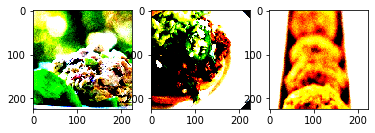

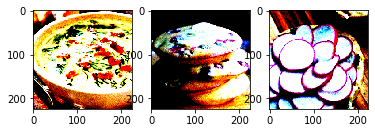

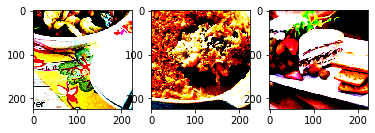

In [11]:
# Plot some images to see how the dataset looks like
# Anchor is more similar in taste to positive than negative

for i in np.random.randint(0,100,3):
  fig, ax = plt.subplots(1,3)
  anch, pos, neg = dataset[i]
  ax[0].imshow(anch.permute(1,2,0))
  ax[1].imshow(pos.permute(1,2,0))
  ax[2].imshow(neg.permute(1,2,0))

### Train the model

In [ ]:
%prun #<---- whats this?

importlib.reload(model)
importlib.reload(helpers)
importlib.reload(preprocessing)

### PARAMETERS of the network###
device = device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ' + device)

net = model.EmbeddingNetwork(image_size,image_size).to(device)
criterion = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(net.parameters())
epochs = 1
###############################

#%%
trainloader = torch.utils.data.DataLoader(dataset,batch_size = train_batch_size, shuffle=True, 
                                          pin_memory=True, num_workers = 2)
#%%

In [12]:
losses = list() # for bookkeeping
counter = 0
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        counter += 1
        # get the inputs; data is a list of [inputs, labels]
        anchors, positives, negatives = data

        # this is still pretty slow. We should try to get entire tensor to GPU
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        anchor_out = net(anchors)
        pos_out = net(positives)
        neg_out = net(negatives)
        loss = criterion(anchor_out, pos_out, neg_out)
        loss.backward()
        optimizer.step()

        # print statistics THIS MAKES IT SLOW so don't be too ambitious on this
        if counter % 40 == 0:
          loss_fl = loss.item()
          running_loss += loss_fl
          losses.append(loss_fl)

        if i % 2000 == 1999:    # print loss every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


#%%
plt.plot(losses)

# Save the model
torch.save(net.state_dict(), root_path + "assets/")

 Using device: cpu


PicklingError: Can't pickle <class 'preprocessing.TripletDataset'>: it's not the same object as preprocessing.TripletDataset

In [ ]:
# Comput a prediction

#load_the_model

importlib.reload(model)
importlib.reload(helpers)
importlib.reload(preprocessing)

#%%
device = device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ' + device)
importlib.reload(preprocessing)
net = model.EmbeddingNetwork(image_size,image_size).to(device)
#net.load_state_dict(torch.load(root_path + 'model.pt'))

# Build the dataset for the test set
test_dataset = preprocessing.TripletDataset('assets/test_triplets.txt', 'assets/food/', transform = composed_trafo)

# Prepare the predicitons
prediction = np.zeros(len(test_dataset))

# Compute the output of each triplet and compute the eucledian distance between
# a-b and a-c. Which ever is smaller will be the prediciton
# may need to put a no_grad somewhere

for i in range(len(test_dataset)):
    achors, positives, negatives = test_dataset[i]
    anchors = anchors.to(device)
    positives = positives.to(device)
    negatives = negatives.to(device)
    a = net(anchors)
    b = net(positives)
    c = net(negatives)
    ab = torch.cdist(a,b,p=2.0)
    ac = torch.cdist(a,c,p=2.0)

if (ab < ac):
    predictions[i] = 1

pd.Dataframe(predictions, header = False, label = False).to_csv(root_path + 'predictions1.csv')